In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import read_image, ImageReadMode
from data_transform import get_transform
from torchvision.models.detection import maskrcnn_resnet50_fpn

In [26]:
image = read_image("/home/mapaction/Documents/Exp-data/test_img/test1.jpg.png", mode=ImageReadMode.RGB)
eval_transform = get_transform(train=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = maskrcnn_resnet50_fpn(weights="DEFAULT")
current_model_dict = model.state_dict()
loaded_state_dict = torch.load('/home/mapaction/mapaction_env/Map-Action-Model/model/test11.pth')
new_state_dict={k:v if v.size()==current_model_dict[k].size()  else  current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
model.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

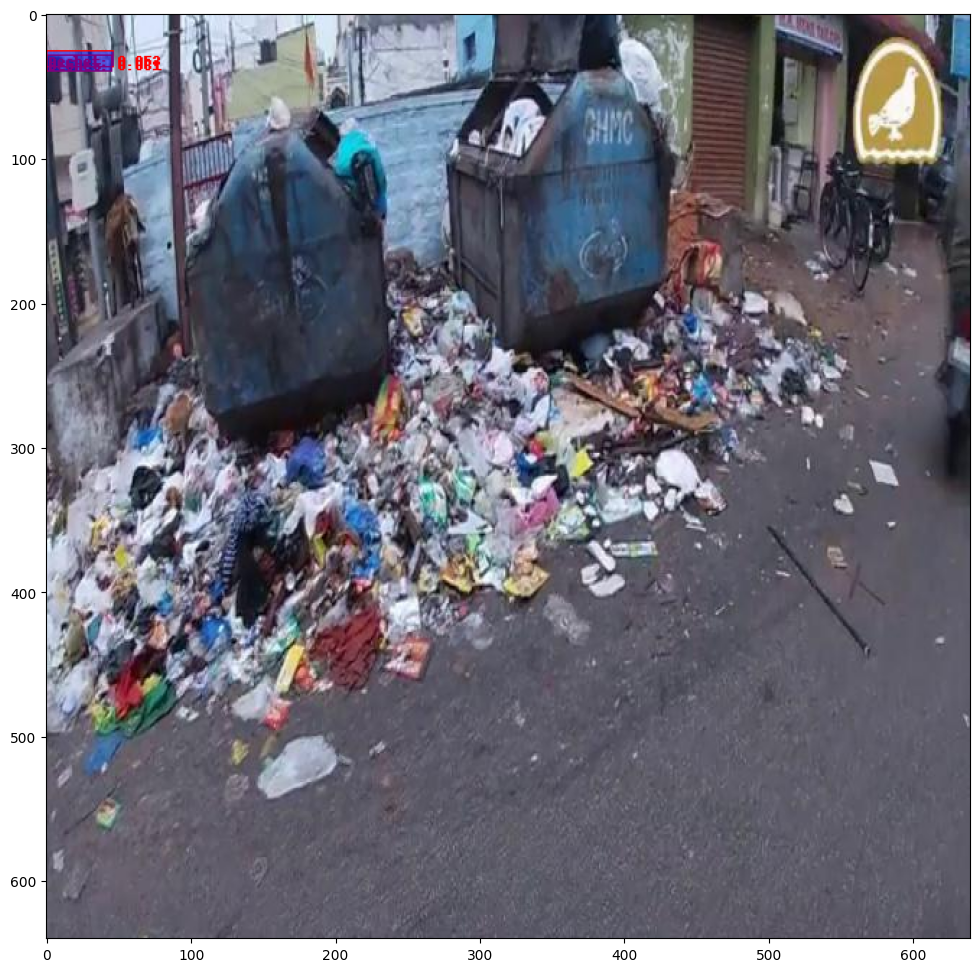

In [29]:
model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"Dechet: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.4).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))